
## 📌 Feature Engineering Plan

Based on the exploratory data analysis (EDA) conducted, we can now outline a structured plan to guide the feature engineering process. The following steps will be followed:

1. **Create a `'Month'` Feature**  
   Extract the month from the date column to capture potential seasonal trends in rainfall.

2. **Remove Outliers**  
   Identify and eliminate extreme values that may distort the model’s performance.

3. **Address Skewness**  
   Apply transformations (e.g., log, Box-Cox) to reduce skewness in numerical features where necessary.

4. **Remove Highly Correlated Features**  
   Drop redundant features that show strong correlation with each other to reduce multicollinearity.

5. **Handle Missing Values**  
   - If a feature has a high percentage of missing values, it will either be dropped or a new category such as `'Missing'` will be created (for categorical features).  
   - If the percentage of missing values is moderate or low, different imputation strategies will be tested.

6. **Create New Features**  
   Engineer additional features based on domain knowledge or variable interactions that may improve model performance.

7. **Encoding**  
   - Apply suitable encoding techniques (e.g., One-Hot Encoding, Ordinal Encoding) to categorical features for compatibility with machine learning algorithms.

In [75]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

In [24]:
# Load dataset
df = pd.read_csv('../data/raw/weatherAUS.csv')
target = 'RainTomorrow'
# Drop target labels that are null
df.dropna(subset=[target], inplace=True)
# Convert both target and RainToday feature into boolean
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

print(f'Dataframe shape: {df.shape}')
df.head(3)

Dataframe shape: (142193, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0


In [25]:
df['Date'] = pd.to_datetime(df['Date'])
num_features = df.select_dtypes(include=np.number).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()

# 1. Create `'Month'` feature

In [26]:
df['Month'] = df['Date'].dt.month

# 2. Remove outliers

In [27]:
features_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

In [28]:
def filter_outliers_by_percentile(df, features, percentile=0.99):
    """
    Remove rows where any value in specified features exceeds the given percentile threshold.
    Only filters the upper tail (high values) as outliers.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of columns to check for outliers.
        percentile (float): Percentile threshold (between 0 and 1). Rows with values above this percentile are removed.

    Returns:
        pd.DataFrame: DataFrame without rows exceeding the specified percentile in any of the features.
    """
    df_clean = df.copy()
    outlier_indices = set()
    
    for col in features:
        threshold = df_clean[col].quantile(percentile)
        col_outliers = df_clean[df_clean[col] > threshold].index
        outlier_indices.update(col_outliers)
        
    initial_rows = df_clean.shape[0]
    df_clean = df_clean.drop(index=outlier_indices)
    final_rows = df_clean.shape[0]
    
    print(f"Rows removed due to upper {100*(1-percentile):.2f}% outliers: {initial_rows - final_rows}")
    return df_clean

# Ejemplo de uso:
df = filter_outliers_by_percentile(df, features_with_outliers, 0.99)

Rows removed due to upper 1.00% outliers: 4944


# 3. Address skewness

In [29]:
#df[num_features].skew().sort_values()

In [30]:
#def get_skewed_features(df, threshold=0.5):
#    """
#    Returns a Series of numerical features with skewness < -threshold or > threshold.
#    
#    Parameters:
#        df (pd.DataFrame): The input DataFrame.
#        threshold (float): Skewness threshold to detect features to be treated.
#    
#    Returns:
#        pd.Series: Features with strong skewness.
#    """
#    numeric_cols = df.select_dtypes(include=['number']).columns
#    skew_values = df[numeric_cols].skew()
#    skewed = skew_values[(skew_values > threshold) | (skew_values < -threshold)]
#    return skewed.index.to_list()
#
#skewed_features = get_skewed_features(df, threshold=0.5)
#skewed_features.remove('RainTomorrow')
#print("Skewed features:", skewed_features)

In [31]:
#from sklearn.preprocessing import PowerTransformer
#
#def treat_skewness(df, features):
#    """
#    Apply transformations to reduce skewness in numeric features.
#    Uses Box-Cox for strictly positive data and Yeo-Johnson otherwise.
#    
#    Parameters:
#        df (pd.DataFrame): DataFrame with numeric features.
#        features (list): List of feature names to transform.
#    
#    Returns:
#        pd.DataFrame: DataFrame with transformed features.
#    """
#    df_transformed = df.copy()
#    
#    for feature in features:
#        data = df_transformed[feature].values.reshape(-1, 1)
#        if (df_transformed[feature] > 0).all():
#            # Use Box-Cox transformation
#            pt = PowerTransformer(method='box-cox')
#        else:
#            # Use Yeo-Johnson transformation for zero or negative values
#            pt = PowerTransformer(method='yeo-johnson')
#        
#        try:
#            df_transformed[feature] = pt.fit_transform(data).flatten()
#        except Exception as e:
#            print(f"Could not transform feature {feature}: {e}")
#    
#    return df_transformed
#
## Ejemplo de uso:
## features_to_treat = ['Rainfall', 'Temperature', 'WindGustSpeed']
#df = treat_skewness(df, skewed_features)

# 4. Remove highly correlated features

In [32]:
import pandas as pd
import numpy as np

def remove_highly_correlated_features(df, target, threshold=0.9, strategy='nulls'):
    """
    Removes one of each pair of highly correlated features based on a selection strategy.
    
    Parameters:
        df (pd.DataFrame): The dataset.
        target (str): Name of the target variable.
        threshold (float): Correlation threshold.
        strategy (str): Strategy to drop one variable from each correlated pair. 
                        Options: 'nulls', 'target_corr'.
    
    Returns:
        pd.DataFrame: DataFrame with reduced features.
        list: List of dropped features.
    """
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')
    corr_matrix = df_numeric.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = set()

    for col in upper_tri.columns:
        for row in upper_tri.index:
            corr_value = upper_tri.loc[row, col]
            if pd.notnull(corr_value) and corr_value > threshold:
                # If any of the two has already been dropped, skip
                if row in to_drop or col in to_drop:
                    continue

                if strategy == 'nulls':
                    nulls_row = df[row].isnull().sum()
                    nulls_col = df[col].isnull().sum()
                    drop = row if nulls_row > nulls_col else col

                elif strategy == 'target_corr':
                    if target not in df.columns:
                        raise ValueError("Target column not found in DataFrame.")
                    corr_row = abs(df[[row, target]].corr().iloc[0, 1])
                    corr_col = abs(df[[col, target]].corr().iloc[0, 1])
                    drop = row if corr_row < corr_col else col

                else:
                    raise ValueError("Invalid strategy. Choose 'nulls' or 'target_corr'.")

                to_drop.add(drop)

    reduced_df = df.drop(columns=list(to_drop))
    return reduced_df, list(to_drop)

# Example usage:
df, dropped = remove_highly_correlated_features(df, target='RainTomorrow', threshold=0.9, strategy='target_corr')
print("Dropped features:", dropped)

Dropped features: ['Pressure3pm', 'MaxTemp', 'Temp9am']


# 5. Handling missing values

In [33]:
df.isna().mean().sort_values(ascending=False)

Sunshine         0.477475
Evaporation      0.428739
Cloud3pm         0.404455
Cloud9am         0.380258
Pressure9am      0.099695
WindDir9am       0.072117
WindGustDir      0.065603
WindGustSpeed    0.065174
WindDir3pm       0.026805
Humidity3pm      0.025275
Temp3pm          0.019017
WindSpeed3pm     0.018536
Humidity9am      0.012510
RainToday        0.009924
Rainfall         0.009924
WindSpeed9am     0.009567
MinTemp          0.004510
RainTomorrow     0.000000
Date             0.000000
Location         0.000000
Month            0.000000
dtype: float64

Impute categorical features with the label `'Missing'`

In [34]:
print(df[cat_features].isna().mean())

for col in cat_features:
    df[col] = df[col].fillna('Missing')

Location       0.000000
WindGustDir    0.065603
WindDir9am     0.072117
WindDir3pm     0.026805
dtype: float64


Impute some numerical features by the median, grouped by `'Month'` and `'Location'`

In [35]:
def impute_median_by_group(df, features, group_cols=['Month', 'Location']):
    """
    Impute missing values in specified columns using the median.
    First, impute using group-level median (by group_cols).
    If group-level median is missing, fall back to the global median of the column.

    Args:
        df (pd.DataFrame): Original dataframe.
        features (list): List of columns to impute.
        group_cols (list): Columns to group by for median calculation (default ['Month', 'Location']).

    Returns:
        pd.DataFrame: Dataframe with imputed values.
    """
    df_imputed = df.copy()

    # Group-level medians
    group_medians = df_imputed.groupby(group_cols)[features].transform('median')
    
    for feature in features:        
        df_imputed[feature] = df_imputed[feature].fillna(group_medians[feature])

    return df_imputed


In [36]:
num_features = df.select_dtypes(include=['number']).columns.tolist()

In [37]:
df = impute_median_by_group(df, num_features)

In [38]:
df.isna().mean().sort_values(ascending=False)

Sunshine         0.368185
Evaporation      0.321161
Cloud3pm         0.241379
Cloud9am         0.241379
Pressure9am      0.083709
WindGustSpeed    0.041829
Date             0.000000
Humidity9am      0.000000
RainTomorrow     0.000000
RainToday        0.000000
Temp3pm          0.000000
Humidity3pm      0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Location         0.000000
WindDir3pm       0.000000
WindDir9am       0.000000
WindGustDir      0.000000
Rainfall         0.000000
MinTemp          0.000000
Month            0.000000
dtype: float64

In [39]:
still_nulls = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am', 'Pressure9am', 'WindGustSpeed']
df[still_nulls].describe()

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure9am,WindGustSpeed
count,86716.000000,93170.000000,104120.000000,104120.000000,125760.000000,131508.000000
mean,7.862767,5.094657,4.673737,4.678799,1017.882524,39.094956
std,3.545114,3.262591,2.583820,2.820512,6.930889,12.268522
min,0.000000,0.000000,0.000000,0.000000,980.500000,6.000000
25%,5.500000,2.600000,2.000000,2.000000,1013.300000,31.000000
50%,8.600000,4.600000,5.000000,6.000000,1017.800000,37.000000
75%,10.600000,7.000000,7.000000,7.000000,1022.500000,46.000000
max,14.500000,18.400000,9.000000,9.000000,1041.000000,81.000000


In [40]:
def impute_with_minus_one(df, columns):
    df = df.copy()
    for col in columns:
        df[col] = df[col].fillna(-1)
    return df

df = impute_with_minus_one(df, still_nulls)
df.isna().mean()

Date             0.0
Location         0.0
MinTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Month            0.0
dtype: float64

Since there are locations where some of these features are never measured, imputing by both location and month isn’t possible due to the lack of historical data. Given that all values for these features are—and will always be—positive, we’ll impute missing values with -1. This allows us to clearly flag imputed entries while ensuring compatibility with tree-based models.

# 6. Create new features  

In [64]:
dir_map = {'N':0, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE':112.5,
           'SE':135, 'SSE':157.5, 'S':180, 'SSW':202.5, 'SW':225, 'WSW':247.5,
           'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5}
df['WindGustDir_deg'] = df['WindGustDir'].map(dir_map)
df['WindDir9am_deg'] = df['WindDir9am'].map(dir_map)
df['WindDir3pm_deg'] = df['WindDir3pm'].map(dir_map)

In [66]:
# Aux function to detect de feature name (removing the time). For example, Humidity9am -> Humidity
def text_before_number(name):
    match = re.match(r'^([^\d]+)', name)
    return match.group(1) if match else ''

# Aux function to detect all those features that contains 9am or 3pm, which are going to be used to calculate the climate differences during the day
def filter_columns(cols):
    return [col for col in cols if '9am' in col or '3pm' in col]

In [67]:
climate_difference_features = filter_columns(df.columns.to_list())
climate_difference_features

['WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Cloud9am',
 'Cloud3pm',
 'Temp3pm',
 'WindDir9am_deg',
 'WindDir3pm_deg']

In [68]:
def climate_difference(df, feature_3pm, feature_9am):
    df_ = df.copy()

    feature = text_before_number(feature_3pm)
    df_[f'{feature}_Difference'] = df_[feature_3pm] - df_[feature_9am]

    return df_

In [71]:
df = climate_difference(df, 'WindSpeed3pm', 'WindSpeed9am')
df = climate_difference(df, 'Humidity3pm', 'Humidity9am')
df = climate_difference(df, 'Cloud3pm', 'Cloud9am')
df = climate_difference(df, 'WindDir3pm_deg', 'WindDir9am_deg')

# 7. Encoding

In [ ]:
def label_encode_features(df, columns):
    df = df.copy()
    encoders = {}
    
    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le  # Optional: store encoders if you need to inverse transform later
    
    return df, encoders

In [82]:
df, label_encoders = label_encode_features(df, cat_features)

---

In [85]:
to_drop = ['Date', 'WindGustDir']
df.drop(to_drop, axis=1, inplace=True)

In [91]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Separar features y target
target_column = 'RainTomorrow'
X = df.drop(columns=[target_column])
y = df[target_column]

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parámetros del modelo
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

# Entrenar el modelo
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
)

# Predecir probabilidades y clases
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8634608378870674
ROC AUC: 0.8908923260677588
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     21542
           1       0.76      0.54      0.63      5908

    accuracy                           0.86     27450
   macro avg       0.82      0.75      0.77     27450
weighted avg       0.86      0.86      0.85     27450



In [93]:
# Obtener importancias
importances = model.feature_importance(importance_type='gain')  # También puedes usar 'split'
feature_names = model.feature_name()

# Crear DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                 Feature     Importance
11           Humidity3pm  253209.615747
5          WindGustSpeed   48661.911138
12           Pressure9am   44811.199889
4               Sunshine   35490.292562
0               Location   27029.478810
2               Rainfall   24868.068138
1                MinTemp   22442.238081
15               Temp3pm   18462.731822
21       WindGustDir_deg   14472.478275
19   Humidity_Difference   13225.308296
14              Cloud3pm   12401.216939
23        WindDir3pm_deg   12296.991105
10           Humidity9am   11291.841923
22        WindDir9am_deg   11243.212675
24    WindDir_Difference   10439.058425
7             WindDir3pm    9318.523389
17                 Month    8206.042986
9           WindSpeed3pm    8095.595485
3            Evaporation    7990.903213
18  WindSpeed_Difference    7370.164802
8           WindSpeed9am    6118.365140
6             WindDir9am    5422.214040
20      Cloud_Difference    4030.408940
13              Cloud9am    3939.564983


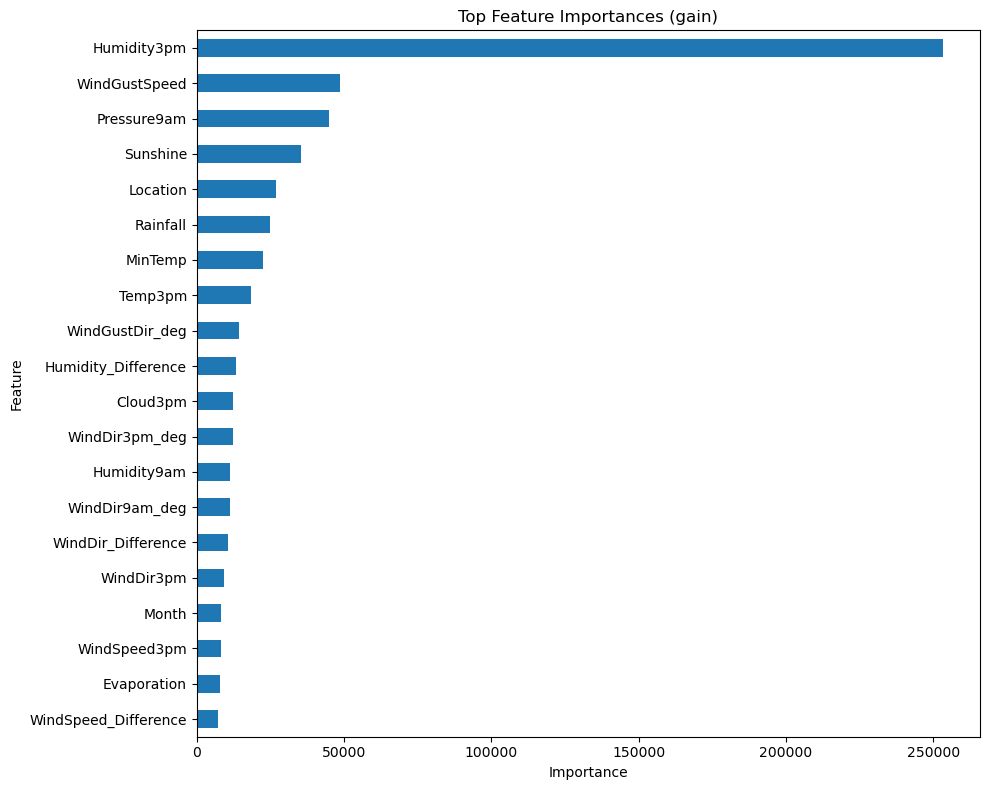

In [94]:
import matplotlib.pyplot as plt

# Plotear las 20 más importantes (puedes cambiar el número)
top_n = 20
feature_importance_df.head(top_n).plot(
    kind='barh',
    x='Feature',
    y='Importance',
    figsize=(10, 8),
    legend=False
)
plt.gca().invert_yaxis()
plt.title('Top Feature Importances (gain)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
